In [2]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

#from mcjax.proba.dist import Dist
from mcjax.proba.neal_funnel import NealFunnel
from mcjax.mcmc.rwm import Rwm
from mcjax.util.mcmc import ESS_geyer, ESS_AR1, normalized_autocorr



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# initialize jax RNG
key = jr.key(0)

### Target concentratin in the neighbourhood of a sub-manifold


In [4]:
DIM = 5
dist = NealFunnel(dim=DIM)

### Run RWM

In [5]:
# random walk metropolis
mcmc = Rwm(logtarget=dist, step_size=0.1, cov=jnp.eye(DIM))

# initial state
x_init = jnp.zeros(DIM)
state_init = mcmc.init_state(x_init)

# run the chain
n_samples = 10_000
key, key_ = jr.split(key)
mcmc_output = mcmc.run(key=key_, state_init=state_init, n_samples=n_samples)

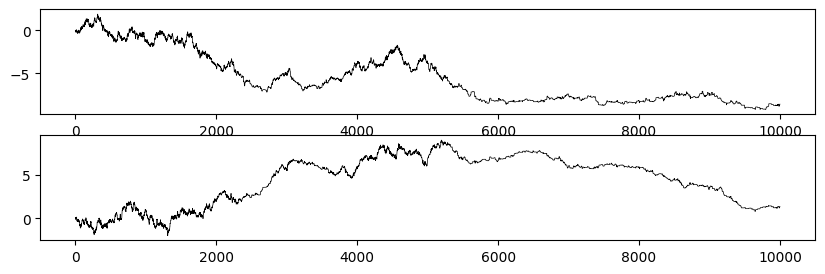

In [6]:
# plot x0 trajectory
plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(mcmc_output["x"][:, 0], color='black', lw=0.5)
plt.subplot(2, 1, 2)
plt.plot(mcmc_output["x"][:, 1], color='black', lw=0.5)

### Influence of the step size

In [10]:
# let's define a function that samples a trajectory -- small wrapper around the `sample_RWM` function
def sample_RWM(key, x0, step_size, n_steps):
    # define the RWM sampler
    mcmc = Rwm(logtarget=dist, step_size=step_size, cov=jnp.eye(DIM))
    # sample the trajectory
    state_init = mcmc.init_state(x0)
    mcmc_output = mcmc.run(key = key, n_samples=n_steps, state_init=state_init)
    return mcmc_output

sample_RWM = jax.jit(sample_RWM, static_argnums=(3,))

# let's define a function that samples a batch of trajectories
# for different step sizes so that we can study the influence of the step size
sample_RWM_batch = jax.vmap(sample_RWM, in_axes=(None, None, 0, None))
sample_RWM_batch = jax.jit(sample_RWM_batch, static_argnums=(3,))


In [11]:
x0 = jnp.zeros(DIM)
step_size = 0.1
n_steps = 100_000
key, key_ = jr.split(key)
mcmc_output = sample_RWM(key_, x0, step_size, n_steps)

In [12]:
step_size_arr = 10.**np.linspace(-2, 1.5, 100)
n_steps = 1_000_000
mcmc_output_batch = sample_RWM_batch(key, x0, step_size_arr, n_steps)


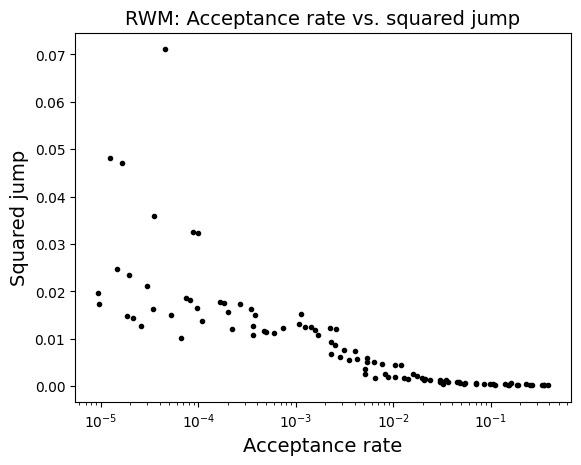

In [ ]:
plt.plot(mcmc_output_batch["acceptance_rate"], mcmc_output_batch["sq_jump"], ".", color='black')
plt.xscale("log")
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Squared jump", fontsize=14)
plt.title("RWM: Acceptance rate vs. squared jump", fontsize=14)

# find the optimal step size by maximizing the squared jump
index_opt = np.argmax(mcmc_output_batch["sq_jump"])
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = mcmc_output_batch["acceptance_rate"][index_opt]

# --> unstable behavior --> has not mixed well